# Nuclei Image Segmentation Tutorial

In this tutorial, we will implement a [UNet](https://arxiv.org/abs/1505.04597) to solve Kaggle's [2018 Data Science Bowl Competition](https://www.kaggle.com/c/data-science-bowl-2018). The challenge asks participants to find the location of nuclei from images of cells. In additional to `skorch`, this tutorial uses `matplotlib` for plotting, `torchvision` for image augmentation and Kaggle's offical cli to download data. Please follow [Kaggle's installation and configuration documentation](https://github.com/Kaggle/kaggle-api#installation) to install the kaggle cli. Next, navigate to the [competition page](https://www.kaggle.com/c/data-science-bowl-2018), click on "Late Submission" and accept the terms and conditions to get access to the data.

In [1]:
%matplotlib inline

from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim import SGD
import torch.nn as nn
from torch.nn.functional import binary_cross_entropy_with_logits

from dataset import CellsDataset, PatchedDataset
from model import UNet
from utils import plot_cells, plot_masks, plot_mask_cells

torch.manual_seed(0);

## Exploring the Data

We define the datasets training and validiation datasets:

In [4]:
with open("train_valid_split.json", "r") as fp:
    train_valid_split = json.load(fp)

train_dirs = [Path(d) for d in train_valid_split["train_dirs"]]
valid_dirs = [Path(d) for d in train_valid_split["valid_dirs"]]

train_cell_ds = CellsDataset(train_dirs)
valid_cell_ds = CellsDataset(valid_dirs)

Overall the cell images come in different sizes, and fall in three different categories:

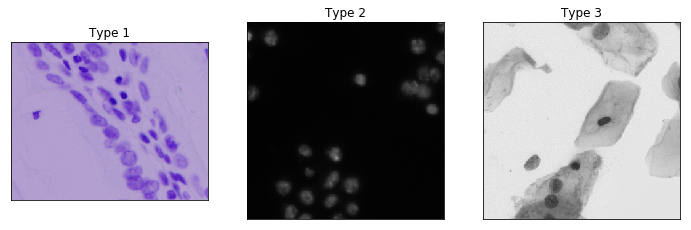

In [5]:
type1_id, type2_id, type3_id = 13, 6, 25
_ = plot_cells(valid_cell_ds[type1_id][0],
           valid_cell_ds[type2_id][0],
           valid_cell_ds[type3_id][0].crop((200, 200, 500, 500)))

Most of the data is of Type 2. Training a single model to be able to find the nuclei for all types may not be the best option, but we will give it a try! For reference here are the corresponding masks for the above three types:

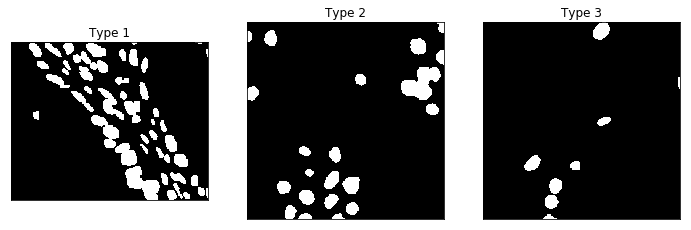

In [6]:
_ = plot_masks(valid_cell_ds[type1_id][1],
               valid_cell_ds[type2_id][1],
               valid_cell_ds[type3_id][1].crop((200, 200, 500, 500)))

In order to train a neutral net, each image we feed in must be the same size. For our dataset, we break our images up into 256x256 patches. The UNet architecture typically has a hard time dealing with objects on the edge of an image. In order to deal with this issue, we pad our images by 16 using reflection. The image augmentation is handled by `PatchedDataset`. Its implementation can be found in `dataset.py`.

In [7]:
train_ds = PatchedDataset(
    train_cell_ds, patch_size=(256, 256), padding=16, random_flips=True)
val_ds = PatchedDataset(
    valid_cell_ds, patch_size=(256, 256), padding=16, random_flips=False)

## Defining the Module

Now we define the UNet module with the pretrained `VGG16_bn` as a feature encoder. The details of this module can be found in `model.py`:

In [8]:
module = UNet(pretrained=True)

The features generated by `VGG16_bn` are prefixed with `conv`. These weights will be frozen using skorch's `Freezer` callback, which restricts training to only our decoder layers. 

In [10]:
from skorch.callbacks import Freezer
freezer = Freezer('conv*')

## Approximating the IOU Metric

The IOU metric compares two binary masks by dividing their intersection by their union. The UNet module outputs the logit of a probability mask for any given image. One option would be to define a threshold, to convert the predicted probability mask into a binary mask. In this tutorial, we will approximate the IOU metric that can handle the predicted probability mask:

In [11]:
def approximate_iou_metric(true_masks, predicted_logit_masks, padding=16):
    true_masks = true_masks[:, padding:-padding, padding:-padding]
    predicted_logit_masks = predicted_logit_masks[:, padding:-padding, padding:-padding]
    predicted_masks = 1/(1+np.exp(-predicted_logit_masks))
    
    approx_intersect = np.sum(np.minimum(predicted_masks, true_masks), axis=(1,2))
    approx_union = np.sum(np.maximum(predicted_masks, true_masks), axis=(1,2))
    return np.mean(approx_intersect/approx_union)

For `skorch` to record this metric into its history, we create a `EpochScoring` that is our IOU metric:

In [12]:
from skorch.callbacks import EpochScoring
from skorch.utils import to_numpy

def iou_scoring(net, ds, y):
    predicted_logit_masks = net.predict(ds)
    return approximate_iou_metric(y, predicted_logit_masks)

iou_scoring = EpochScoring(iou_scoring, name='iou', lower_is_better=False)

## Learning Rate Scheduler

We use a Cyclic Learning Rate scheduler to train our neutral network.

In [13]:
from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import CyclicLR

cyclicLR = LRScheduler(policy=CyclicLR, 
                       base_lr=0.002, 
                       max_lr=0.2,
                       step_size_up=540,
                       step_size_down=540)

**Why is step_size_up 540?**

Since we are using a batch size of 32, each epoch will have about 54 (`len(train_ds)//32`) training iterations. We are also setting `max_epochs` to 20, which gives a total of 1080 (`max_epochs*54`) training iterations. We construct our Cyclic Learning Rate policy to peak at the 10th epoch by setting `step_size_up` to 540. This can be shown with a plot of the learning rate:

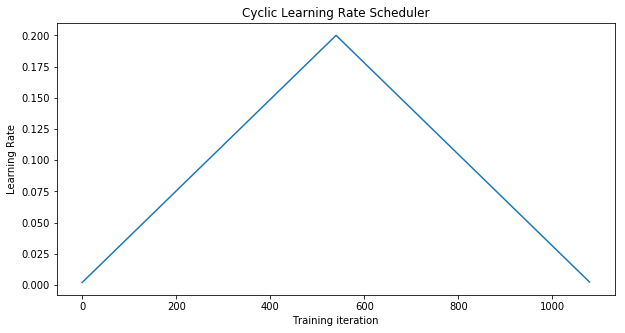

In [14]:
_, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Cyclic Learning Rate Scheduler')
ax.set_xlabel('Training iteration')
ax.set_ylabel('Learning Rate')
_ = ax.plot(cyclicLR.simulate(1080, 0.002))

## Custom Loss Module

Since we have padded our images and mask, the loss function will need to ignore the padding when calculating the binary log loss. We define a `BCEWithLogitsLossPadding` to filter out the padding:

In [15]:
class BCEWithLogitsLossPadding(nn.Module):
    def __init__(self, padding=16):
        super().__init__()
        self.padding = padding

    def forward(self, input, target):
        input = input.squeeze_(
            dim=1)[:, self.padding:-self.padding, self.padding:-self.padding]
        target = target.squeeze_(
            dim=1)[:, self.padding:-self.padding, self.padding:-self.padding]
        return binary_cross_entropy_with_logits(input, target)

## Training Skorch NeutralNet

Now we can define the `skorch` NeutralNet to train out UNet!

In [16]:
from skorch.callbacks import Checkpoint
from skorch.net import NeuralNet
from skorch.helper import predefined_split

net = NeuralNet(
    module,
    criterion=BCEWithLogitsLossPadding,
    criterion__padding=16,
    batch_size=32,
    max_epochs=20,
    optimizer=SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=4,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=4,
    train_split=predefined_split(val_ds),
    callbacks=[freezer,
               cyclicLR, 
               iou_scoring,
               Checkpoint(f_params='best_params.pt')],
    device='cuda',
)

Let's highlight some parametesr in our `NeutralNet`:

1. `criterion__padding=16` - Passes the padding to our `BCEWithLogitsLossPadding` initializer. 
2. `train_split=predefined_split(val_ds)` - Sets the `val_ds` to be the validation set during training.
3. `callbacks=[..., Checkpoint(f_params='best_params.pt')]` - Saves the best parameters to `best_params.pt`.

Next we train our UNet with the training dataset:

In [17]:
net.fit(train_ds);

  epoch     iou    train_loss    valid_loss    cp      dur
-------  ------  ------------  ------------  ----  -------
      1  0.0841        0.4901        0.4193     +  48.3133
      2  0.1483        0.3807        0.3332     +  47.0032
      3  0.3019        0.2832        0.2309     +  47.1726
      4  0.5223        0.1709        0.1376     +  47.1193
      5  0.6145        0.1109        0.1003     +  47.3325
      6  0.6808        0.0830        0.0861     +  47.2606
      7  0.7023        0.0770        0.0657     +  47.1468
      8  0.7221        0.0646        0.0597     +  47.1609
      9  0.7606        0.0584        0.0555     +  47.1527
     10  0.7527        0.0604        0.0525     +  47.1369
     11  0.7547        0.0563        0.0530        47.1609
     12  0.7717        0.0532        0.0505     +  47.5021
     13  0.7687        0.0529        0.0504     +  47.2477
     14  0.7741        0.0520        0.0499     +  47.2537
     15  0.7751        0.0514        0.0494     +  47.10

Before we evaluate our model, we load the best weights into the `net` object:

In [18]:
net.load_params(f_params='best_params.pt')

## Evaluating our model

Now that we trained our model, lets see how we did with the three types presented at the beginning of this tutorial. Since our UNet module, is designed to output logits, we must convert these values to probabilities:

In [19]:
val_masks = net.predict(val_ds).squeeze(1)
val_prob_masks = 1/(1 + np.exp(-val_masks))

We plot the predicted mask with its corresponding true mask and original image:

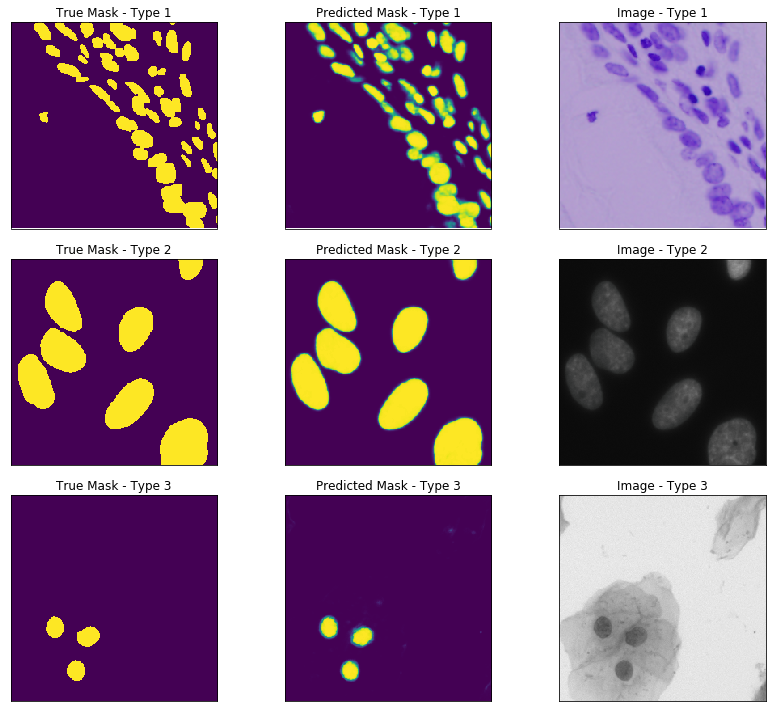

In [20]:
mask_cells = []
for case_id in [45, 8, 81]:
    cell, mask = val_ds[case_id]
    mask_cells.append((mask, val_prob_masks[case_id], cell))

_ = plot_mask_cells(mask_cells)

Our UNet is able to predict the location of the nuclei for all three types of cell images!

## Whats next?

In this tutorial, we used `skorch` to train a UNet to predict the location of nuclei in an image. There are still areas that can be improved with our solution:

1. Since there are three types of images in our dataset, we can improve our results by having three different UNet models for each of the three types. 
2. We can use traditional image processing to fill in the holes that our UNet produced.
3. Our loss function can include a loss analogous to the compeititon's metric of intersection over union.